In [1]:
import numpy as np                           # 导入numpy库并简写为np
from mindquantum.core.gates import X, H      # 导入量子门H, X
from mindquantum.simulator import Simulator  # 从mindquantum.simulator中导入Simulator类
from mindquantum.core.circuit import Circuit # 导入Circuit模块，用于搭建量子线路
from mindquantum.core.gates import Measure   # 引入测量门

/home/yuxuan/.conda/envs/mindspore/lib/python3.9/site-packages/mindquantum/__init__.py:28: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import (


## State vector

In [2]:
nqubits = 8

In [3]:
niter = 40
# postfix = 'slater_plus_4to8layers_40iter'
qasm_texts = []
diags = np.zeros((niter, 2**nqubits), dtype=complex)

for i in range(niter):
    with open(f'saved_models/{i}iter_6layers_slater_full_4to8layers_40iter.qasm') as file:
        qasm_texts.append(file.read())
    diags[i] = np.load(f'saved_models/{i}iter_6layers_diag_slater_full_4to8layers_40iter.npy')

In [4]:
def reorder_qubits(x, nqubits):
    return np.transpose(x.reshape([2] * nqubits)).reshape(-1)

In [5]:
from scipy.linalg import eigh

In [6]:
stvec = eigh(np.loadtxt('slater/Slater_InputState.txt', dtype=complex, delimiter=","))[1][:,-1] # this input state is a density matrix

In [7]:
ground_trurh_val = stvec.conjugate().T @ np.loadtxt("slater/Slater_Ham8.txt", dtype=complex, delimiter=",") @ stvec
ground_trurh_val

(-0.009779661304451022+0.00809319545972615j)

In [8]:
import re
import math

def find_eval_replace_expressions(input_string):
    pattern = r'(\d*)/\((\d*)\*pi\)|(\d*)\*pi/(\d*)'
    matches = re.finditer(pattern, input_string)
    updated_string = input_string
    for match in matches:
        num1 = match.group(1) if match.group(1) else match.group(3)
        num2 = match.group(2) if match.group(2) else match.group(4)
        result = eval(f'{num1} / {num2} * math.pi')
        expression = match.group(0)
        updated_string = updated_string.replace(expression, str(result), 1)  # 仅替换第一个匹配项

    return updated_string

In [9]:
#from mindquantum.io import OpenQASM

#circuit = OpenQASM().from_string(find_eval_replace_expressions(qasm_texts[0]))
#circuit.svg()

In [10]:
from mindquantum.io import OpenQASM
estval = 0
sim = Simulator('mqvector', nqubits)

for i in range(niter):
    circuit = OpenQASM().from_string(find_eval_replace_expressions(qasm_texts[i]))
    sim.reset()
    sim.set_qs(reorder_qubits(stvec, nqubits))
    sim.apply_circuit(circuit)
    resstvec = sim.get_qs()
    diags_flip = reorder_qubits(diags[i], nqubits)
    estval += resstvec.conjugate() @ np.diag(diags_flip) @ resstvec

estval_st = estval

estval_st

(-0.009787907207690289+0.008714676504062272j)

## Sampling

In [11]:
importance = np.max(np.abs(diags), axis=1)

In [12]:
importance /= np.sum(importance)

In [13]:
import matplotlib.pyplot as plt

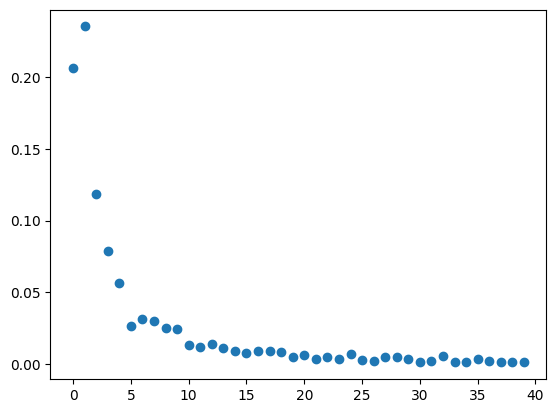

In [14]:
plt.scatter(range(niter), importance)

In [15]:
def estimate_diag(diag_obs, bit_string_data, nshots):
    x = np.array([[n if (j==int(bs, 2)) else 0 for j in range(len(diag_obs))] for bs, n in (bit_string_data.items())])
    x = np.sum(x, axis=0)
    return np.sum(x * diag_obs) / nshots

In [22]:
import math

sim = Simulator('mqvector', nqubits)
nruns = 50

def estimtate(nshots_total):
    estval_list_run = np.zeros(nruns, dtype=complex)
    nshots_iter = [math.floor(nshots_total * x) for x in importance]
    for i in range(niter):
        if nshots_iter[i]:
            circuit = OpenQASM().from_string(find_eval_replace_expressions(qasm_texts[i]))
            for j in range(nqubits):
                circuit += Measure(f'q{j}').on(j)
            diags_flip = reorder_qubits(diags[i], nqubits)
            for j in range(nruns):
                sim.reset()
                sim.set_qs(reorder_qubits(stvec, nqubits))
                result = sim.sampling(circuit, shots=nshots_iter[i])
                contribution = estimate_diag(diags_flip, result.bit_string_data, nshots_iter[i])
                estval_list_run[j] += contribution
    return estval_list_run

In [23]:
nshots_total_list = [100, 200, 500]
estval_list = np.array([estimtate(n) for n in nshots_total_list]).T

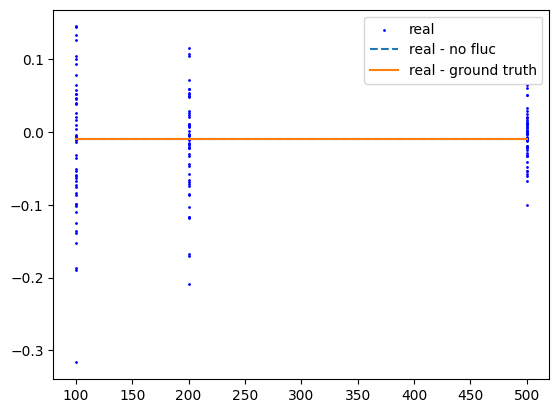

In [24]:
for j in range(nruns):
    if j==0:
        label = "real"
    else:
        label = None
    plt.scatter(nshots_total_list, estval_list[j], c='blue', s=1, label=label)
plt.plot(nshots_total_list, [estval_st.real] * len(nshots_total_list), "--", label="real - no fluc")
plt.plot(nshots_total_list, [ground_trurh_val.real] * len(nshots_total_list), label="real - ground truth")
plt.legend()

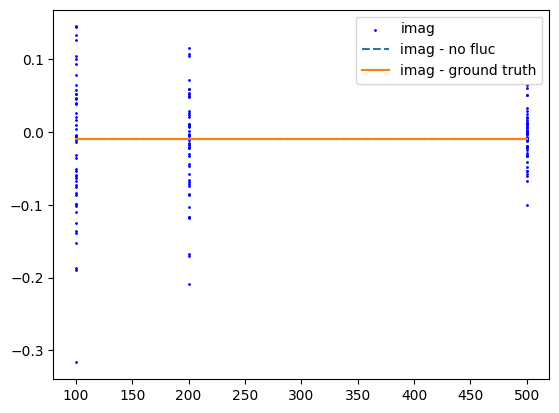

In [26]:
for j in range(nruns):
    if j==0:
        label = "imag"
    else:
        label = None
    plt.scatter(nshots_total_list, estval_list[j], c='blue', s=1, label=label)
plt.plot(nshots_total_list, [estval_st.real] * len(nshots_total_list), "--", label="imag - no fluc")
plt.plot(nshots_total_list, [ground_trurh_val.real] * len(nshots_total_list), label="imag - ground truth")
plt.legend()

In [28]:
errors = np.array(estval_list)
errors -= ground_trurh_val
# errors -= estval.real
errors = np.sqrt(np.sum(np.abs(errors)**2, axis=0) / nruns)

In [29]:
errors

array([0.12514098, 0.09281931, 0.05417415])

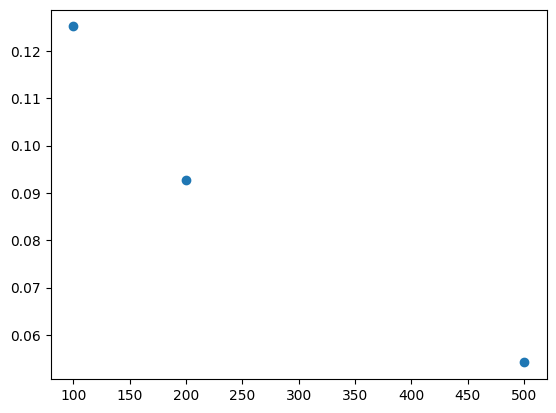

In [30]:
plt.scatter(nshots_total_list, errors)

In [31]:
# np.savetxt('plotdata/slater_error.txt', errors)